In [13]:
library(raster)
library(ggplot2)

# Funciones de ayuda para graficar información raster

In [20]:
':=' <- function(lhs, rhs) {
  frame <- parent.frame()
  lhs <- as.list(substitute(lhs))
  if (length(lhs) > 1)
    lhs <- lhs[-1]
  if (length(lhs) == 1) {
    do.call(`=`, list(lhs[[1]], rhs), envir=frame)
    return(invisible(NULL)) 
  }
  if (is.function(rhs) || is(rhs, 'formula'))
    rhs <- list(rhs)
  if (length(lhs) > length(rhs))
    rhs <- c(rhs, rep(list(NULL), length(lhs) - length(rhs)))
  for (i in 1:length(lhs))
    do.call(`=`, list(lhs[[i]], rhs[[i]]), envir=frame)
  return(invisible(NULL)) 
}

g_legend<-function(a.gplot){
  tmp <- ggplot_gtable(ggplot_build(a.gplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)}
                      
raster_to_df=function(map,n){

  breaks_df=function(vector,n){
    seq(min(vector),max(vector),length.out=n)
  }
  
  reclass_raster=function(breaks){
    n=length(breaks)
    class_matrix=matrix(data=NA,nrow = n-1,ncol = 3)
    count=0
    legenda=c()
    for (i in 1:(n-1)){
      count=count+1
      class_matrix[i,]=c(breaks[i],breaks[i+1],count)
      
      legenda=c(legenda,paste(as.character(round(breaks[i],2)),as.character(round(breaks[i+1],2)),sep = '-'))
    }
    list(matt=class_matrix,legends=legenda)
  }
    
  #map = raster(dir)
  c(matt,legenda):=reclass_raster(breaks = breaks_df(na.omit(values(map)),n))
  
  map = reclassify(map,matt,include.lowest=TRUE)
  
  map.p=rasterToPoints(map)
  df <- data.frame(map.p)
  colnames(df) = c("Longitude", "Latitude", "MAP")
  list(df=df,legenda=legenda)
}

plot_map=function(df.map,legenda,titulo){
  
  #Mypal=gray.colors(length(legenda))
  Mypal=topo.colors(length(legenda))
  #number of intervals
  ggplot(data=df.map, aes(y=Latitude, x=Longitude)) +
    geom_raster(aes(fill=factor(MAP))) +scale_x_continuous(breaks= scales::pretty_breaks(n=4))+
    theme(axis.text.x = element_text(size=10),legend.key.height = unit(0.5, 'cm'),legend.text = element_text(size=10),legend.position="left",plot.title = element_text(hjust = 0.5))+ggtitle(titulo)+
    scale_fill_manual(values =  Mypal,labels=legenda,name=NULL)+
    coord_equal()
  
}

In [21]:
suelo_hidrologico=raster('data/CNN/Tipo_de_Suelo_Hidrologico/Tipo_Suelo.tif')
c(df.map,legenda):=raster_to_df(map = suelo_hidrologico,5)
mapa1=plot_map(df.map,legenda,titulo = 'Tipo de suelo')

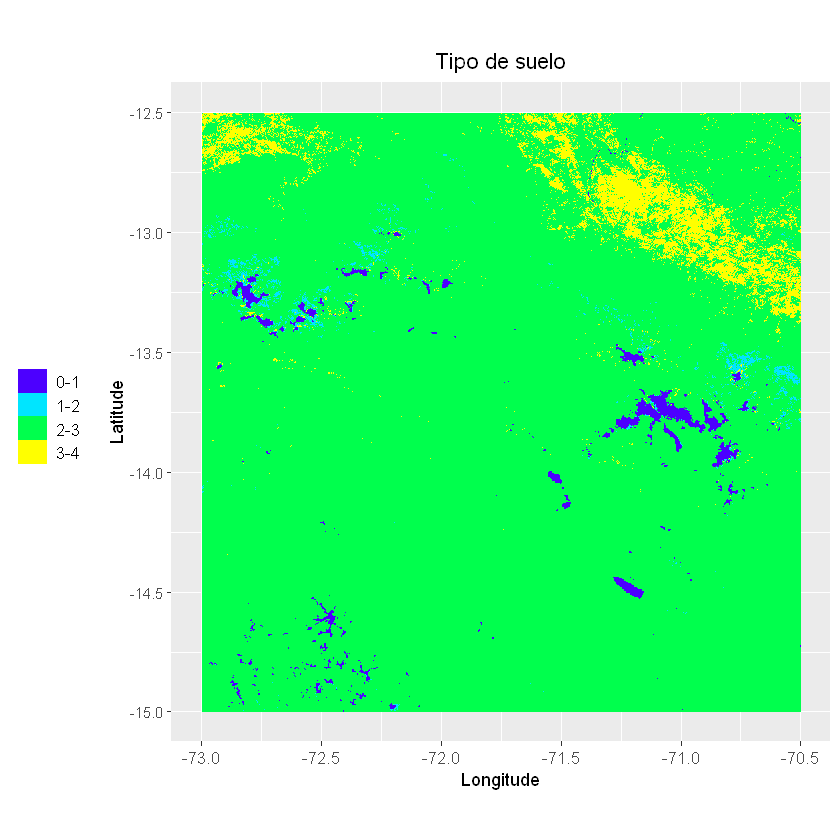

In [22]:
mapa1

Reclasificacion de los usos de suelo

In [24]:
m <- cbind(from = c(-Inf, 5,11,12,13,14,16 ), to = c(5,11,12,13,14,16,17), becomes = c(3,5,4,2,4,5,1))
LU=raster('data/CNN/Uso_de_suelos/Uso_suelos.tif')
LU_reclass=reclassify(LU,m)

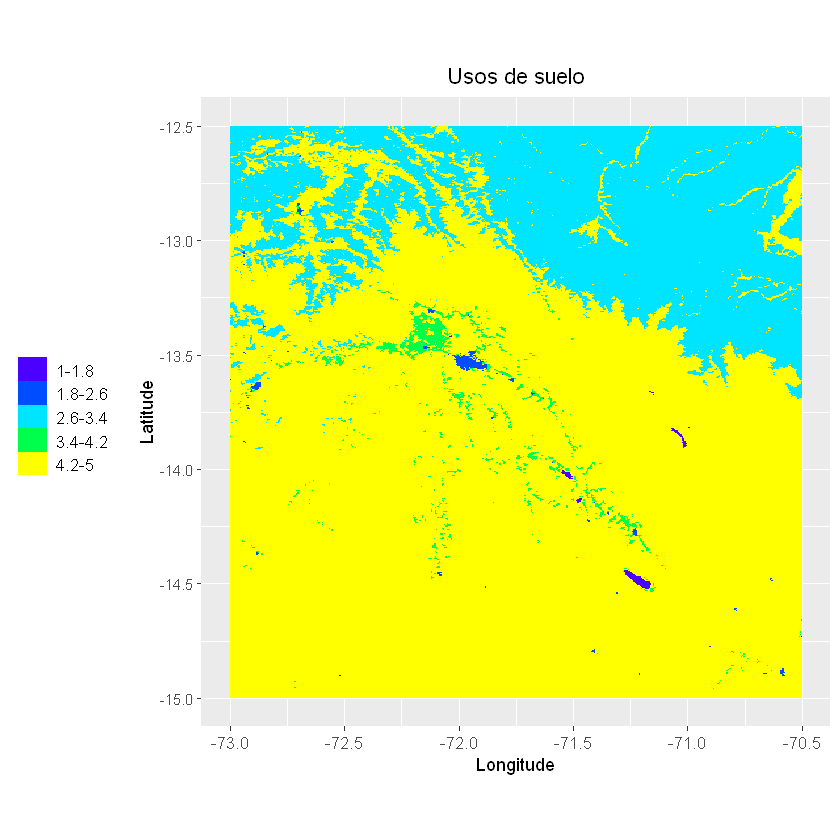

In [45]:
c(df.map,legenda):=raster_to_df(map = LU_reclass,6)
mapa2=plot_map(df.map,legenda,titulo = 'Usos de suelo')
mapa2

<h2> Igualando las resoluciones espaciales de ambos rasters</h2>

In [30]:
LU_reclass=resample(LU_reclass,suelo_hidrologico,method='ngb')

In [31]:
mat=read.csv('data/CNN/CN_Table.csv',sep = ';')
mat

ï..A,B,C,D
100,100,100,100
57,72,81,86
30,58,71,78
67,77,83,87
62,71,78,81


In [32]:
CN=function(x,y){
    "x es el uso de suelo"
    "y es el tipo de suelo hidrologico"
   if (y==0){
     result=0
   }else{
     result=mat[x,y]
   }
   result
}

In [33]:
DF_hidro=as.data.frame(rasterToPoints(suelo_hidrologico))
DF_Uso=as.data.frame(rasterToPoints(LU_reclass))

In [34]:
head(DF_hidro)

x,y,Tipo_Suelo
-72.99896,-12.50104,3
-72.99688,-12.50104,4
-72.99479,-12.50104,4
-72.99271,-12.50104,4
-72.99063,-12.50104,4
-72.98854,-12.50104,4


In [35]:
head(DF_Uso)

x,y,Uso_suelos
-72.99896,-12.50104,3
-72.99688,-12.50104,3
-72.99479,-12.50104,3
-72.99271,-12.50104,3
-72.99063,-12.50104,3
-72.98854,-12.50104,3


In [37]:
df_2r=data.frame(cbind(DF_Uso$Uso_suelos,DF_hidro$Tipo_Suelo))
names(df_2r)=c('x','y')

In [38]:
results=mapply(CN,df_2r$x,df_2r$y)

In [39]:
CN=LU_reclass
values(CN)=results

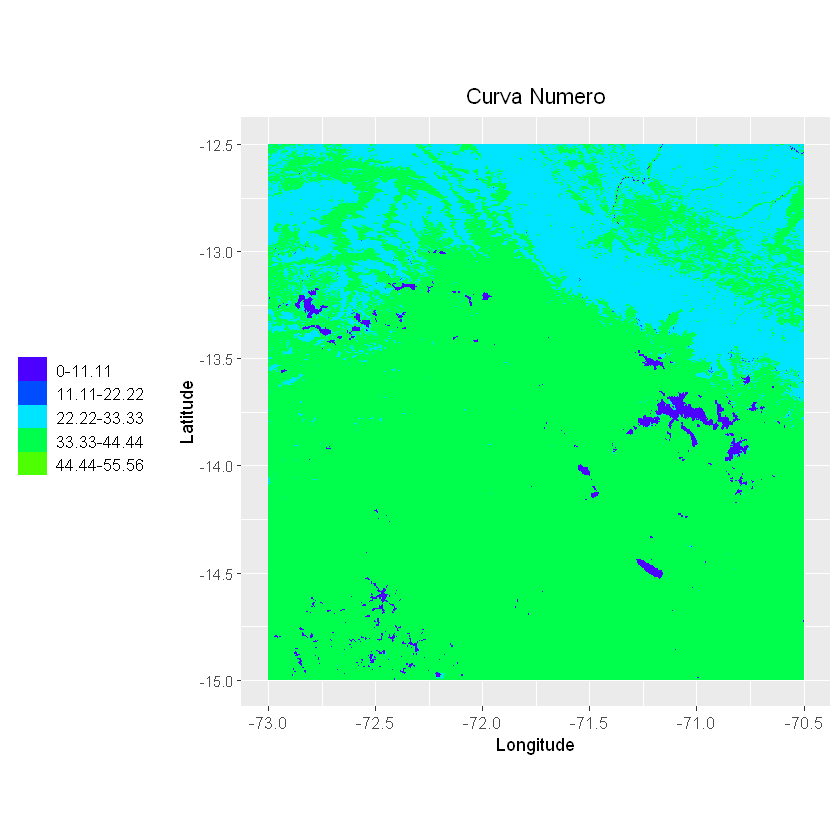

In [44]:
c(df.map,legenda):=raster_to_df(map = CN,10)
mapa3=plot_map(df.map,legenda,titulo = 'Curva Numero')
mapa3